In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 6

# 入力長

In [4]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 2)             0         
                                                                 
 dropout (Dropout)           (None, 16, 2)             0         
                                                                 
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,452
Trainable params: 1,452
Non-trainabl

In [10]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/3 [=========>....................] - ETA: 3s - loss: 1.8042 - accuracy: 0.0312
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.hdf5
3/3 [==============================] - 2s 282ms/step - loss: 1.8033 - accuracy: 0.0391 - val_loss: 1.7938 - val_accuracy: 0.1596
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.8012 - accuracy: 0.0625
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.hdf5
3/3 [==============================] - 0s 39ms/step - loss: 1.7992 - accuracy: 0.0641 - val_loss: 1.7862 - val_accuracy: 0.3298
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.7921 - accuracy: 0.1641
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.hdf5
3/3 [==============================] - 0s 39ms/step - loss: 1.7911 - accuracy: 0.1957 - val_loss: 1.7794 - val_accuracy: 0.4681
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.7865 

In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 360ms/step
[0.5255363  0.07639913 0.06610715 0.05849946 0.16501471 0.10844328]
0


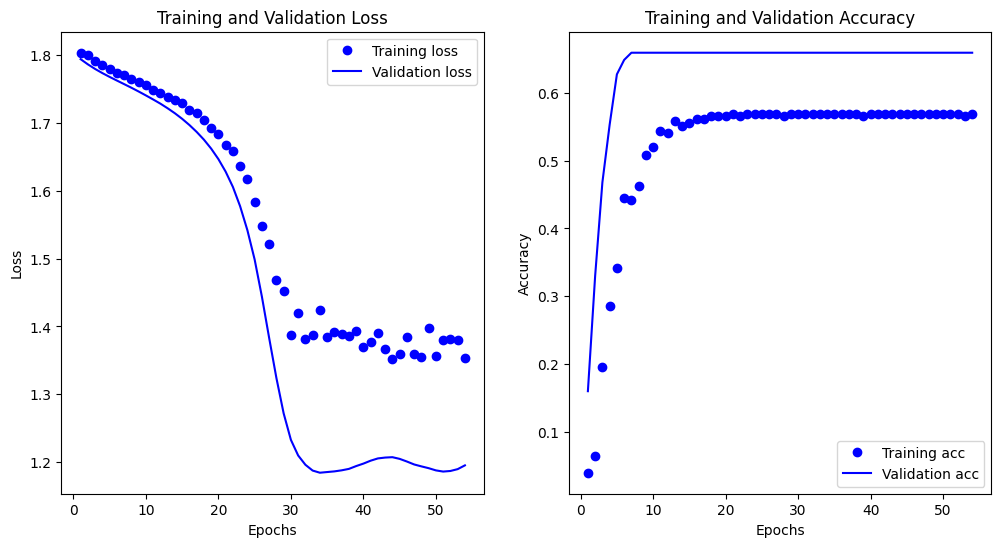

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy thông tin về loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

# 混同行列

3/3 [==============================] - 0s 0s/step


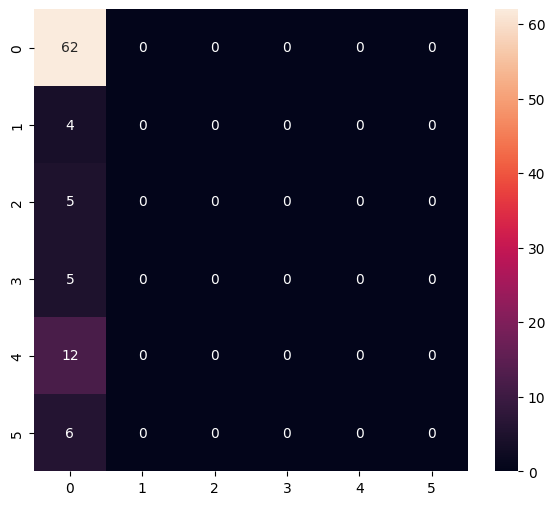

Classification Report
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        62
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         6

    accuracy                           0.66        94
   macro avg       0.11      0.17      0.13        94
weighted avg       0.44      0.66      0.52        94



c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [17]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [18]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [19]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpuf826y3a\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpuf826y3a\assets


ConverterError: c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


# 推論テスト

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'input_1', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9579909  0.01342559 0.00907356 0.01950999]
0
